In [1]:
from pathlib import Path
from artifactremoval.modelarch import *
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
base_dir = Path.cwd().parent
input_dir = base_dir / "data" / "ratings" / "aggregate_data"
test_data = load_most_recent_pickle(input_dir, prefix="spectral_test_")
train_data = load_most_recent_pickle(input_dir, prefix="spectral_train_")
model_dir = base_dir / "data" / "trained_models"
hyperparam_dir = base_dir / "data" / "hyperparam_tuning"

EXPERIMENTS = {
    "baseline_raw"   : ["raw"],
    "raw+water"      : ["raw","water"],
    "raw+fits"       : ["raw","fit1","fit2"],
    "all_four"       : ["raw","water","fit1","fit2"],
    "fits+water"     : ["water","fit1","fit2"],
    "fit1_only"      : ["fit1"],
    "fit2_only"      : ["fit2"],
    "fits_combined"  : ["fit1", "fit2"],
}

bayes_tuner = MyBayesTuner(
    build_model,
    objective="val_accuracy",
    max_trials=40,          # total new BO trials (incl. your seeded 10)
    num_initial_points=0,   # skip random warm-up
    directory=str(hyperparam_dir),
    project_name="bayes_narrowed",
)

# ── 2) Prepare your hyperparameters & model‐factory ───────────────────────
best_trial = bayes_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps = {
    "learning_rate":  best_trial.get("learning_rate"),
    "dropout_rate1":  best_trial.get("dropout_rate1"),
    "dropout_rate2":  best_trial.get("dropout_rate2"),
    "dense_units":    best_trial.get("dense_units"),
    "batch_size":     best_trial.get("batch_size"),
}

Loading most recent file: spectral_test_20250423_1640.pkl
Loading most recent file: spectral_train_20250423_1640.pkl
Reloading Tuner from e:\ArtifactRemovalProject\data\hyperparam_tuning\bayes_narrowed\tuner0.json


In [16]:
# 1) pull out your training labels (strings)
train_labels = [
    e["consensus_rating"]
    for e in train_data
    if e.get("consensus_rating") is not None
]

# 2) fit a fresh encoder
le = LabelEncoder().fit(train_labels)

# ── 1) Load & preprocess your held‐out test set ──────────────────────────
raw_te, wat_te, f1_te, f2_te, y_te, _ = preprocess(test_data, label_encoder=le)

# ── 2) Ensemble the 5 fold‐models for each experiment ───────────────────
ensemble_results = {}
k = 5  # number of folds

In [4]:
from sklearn.metrics import (
    roc_curve, auc, f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, average_precision_score,
    brier_score_loss, matthews_corrcoef
)

# ── Compute and save all relevant metrics per experiment ─────────────────
metrics_data = {}

# 3) Compute and collect all metrics per experiment
metrics_data = {}
for exp_name, channels in EXPERIMENTS.items():
    # a) Ensemble probabilities from 5 folds
    fold_probs = []
    for fold in range(1, 6):
        path = model_dir / f"{exp_name}_tuned_fold{fold}"
        model = tf.keras.models.load_model(path)
        idxs = np.arange(len(y_te))
        X_test = build_tensor(idxs, channels, raw_te, wat_te, f1_te, f2_te)
        p = model.predict(X_test, batch_size=best_hps["batch_size"]).ravel()
        fold_probs.append(p)
    avg_prob = np.mean(fold_probs, axis=0)
    
    # b) ROC/AUC
    fpr, tpr, thr = roc_curve(y_te, avg_prob)
    roc_auc = auc(fpr, tpr)
    
    # c) Thresholded predictions at 0.5
    y_pred = (avg_prob > 0.5).astype(int)
    mcc = matthews_corrcoef(y_te, y_pred)
    
    # d) Basic confusion‐matrix metrics
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    precision    = precision_score(y_te, y_pred)
    recall       = recall_score(y_te, y_pred)
    specificity  = tn / (tn + fp)
    accuracy     = accuracy_score(y_te, y_pred)
    balanced_acc = 0.5 * (recall + specificity)
    
    # e) F1, Sens@95%, AP, Brier
    f1           = f1_score(y_te, y_pred)
    # Sensitivity at 95% specificity
    sens95       = next((t for f, t in zip(fpr, tpr) if 1-f <= 0.05), 0.0)
    average_prec = average_precision_score(y_te, avg_prob)
    brier        = brier_score_loss(y_te, avg_prob)
    
    # f) Youden’s J optimal threshold
    j_scores = tpr - fpr
    idx_j   = np.argmax(j_scores)
    youden_thr = thr[idx_j]
    youden_sens = tpr[idx_j]
    youden_spec = 1 - fpr[idx_j]
    
    # g) Store all
    metrics_data[exp_name] = {
        "fpr":               fpr,
        "tpr":               tpr,
        "thresholds":        thr,
        "auc":               roc_auc,
        "precision":         precision,
        "recall":            recall,
        "specificity":       specificity,
        "accuracy":          accuracy,
        "balanced_accuracy": balanced_acc,
        "mcc":               mcc,
        "f1":                f1,
        "sens95":            sens95,
        "average_precision": average_prec,
        "brier_score":       brier,
        "youden_thr":        youden_thr,
        "youden_sensitivity": youden_sens,
        "youden_specificity": youden_spec,
        "y_prob":            avg_prob,
        "y_pred":            y_pred,
    }


# 4) Save metrics_data to disk
output_dir = base_dir / "results"
output_dir.mkdir(exist_ok=True)
with open(output_dir / "ensemble_metrics_data.pkl", "wb") as f:
    pickle.dump(metrics_data, f)

print(f"Saved metrics for {len(metrics_data)} experiments to '{output_dir}/ensemble_metrics_data.pkl'")


30/30 [==============================] - 5s 117ms/step
Saved metrics for 8 experiments to 'e:\ArtifactRemovalProject\results/ensemble_metrics_data.pkl'


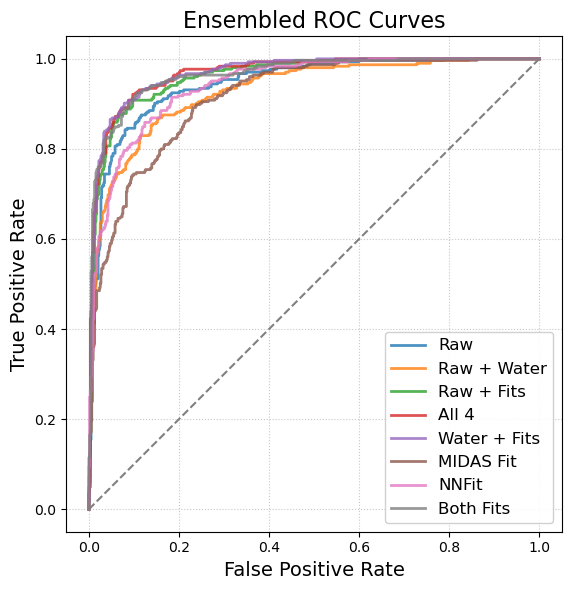

In [8]:
# Load saved data
with open(output_dir / "ensemble_metrics_data.pkl", "rb") as f:
    metrics_data = pickle.load(f)

# Mapping from experiment keys to descriptive labels
label_map = {
    'baseline_raw':  'Raw',
    'raw+water':     'Raw + Water',
    'raw+fits':      'Raw + Fits',
    'all_four':      'All 4',
    'fits+water':    'Water + Fits',
    'fit1_only':     'MIDAS Fit',
    'fit2_only':     'NNFit',
    'fits_combined': 'Both Fits'
}

# Order of experiments for consistent plotting/table
exp_order = [
    'baseline_raw', 'raw+water', 'raw+fits', 'all_four',
    'fits+water', 'fit1_only', 'fit2_only', 'fits_combined'
]

# Prepare table data
table_data = []
for key in exp_order:
    d = metrics_data[key]
    table_data.append([
        f"{d['auc']:.3f}",
        f"{d['precision']:.3f}",
        f"{d['recall']:.3f}"
    ])
col_labels = ['AUC', 'Precision', 'Recall']
row_labels = [label_map[k] for k in exp_order]

plt.figure(figsize=(8,6))
for key in exp_order:
    d = metrics_data[key]
    plt.plot(d["fpr"], d["tpr"], label=label_map[key], linewidth=2, alpha=0.8)
plt.plot([0,1],[0,1],"--", color="gray", linewidth=1.5)

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Ensembled ROC Curves", fontsize=16)
plt.grid(linestyle=":", alpha=0.7)
plt.gca().set_aspect("equal", "box")
plt.legend(fontsize=12, frameon=True, framealpha=0.9, loc="lower right")
plt.tight_layout()
plt.show()



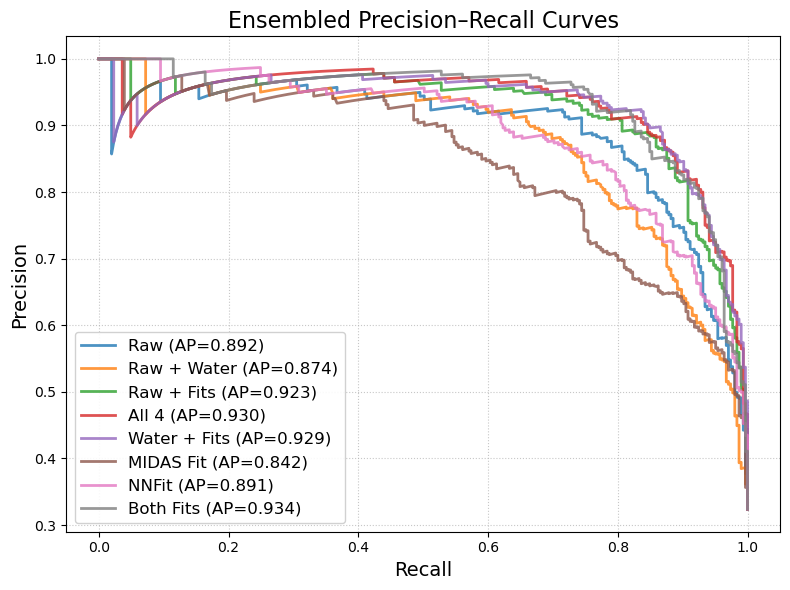

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Descriptive labels and order
label_map = {
    'baseline_raw':  'Raw',
    'raw+water':     'Raw + Water',
    'raw+fits':      'Raw + Fits',
    'all_four':      'All 4',
    'fits+water':    'Water + Fits',
    'fit1_only':     'MIDAS Fit',
    'fit2_only':     'NNFit',
    'fits_combined': 'Both Fits'
}
exp_order = [
    'baseline_raw', 'raw+water', 'raw+fits', 'all_four',
    'fits+water', 'fit1_only', 'fit2_only', 'fits_combined'
]

plt.figure(figsize=(8, 6))
for key in exp_order:
    y_prob = metrics_data[key]['y_prob']
    precision, recall, _ = precision_recall_curve(y_te, y_prob)
    ap = average_precision_score(y_te, y_prob)
    plt.plot(recall, precision,
             label=f"{label_map[key]} (AP={ap:.3f})",
             linewidth=2, alpha=0.8)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Ensembled Precision–Recall Curves", fontsize=16)
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend(fontsize=12, loc="lower left", framealpha=0.9)
plt.tight_layout()
plt.show()

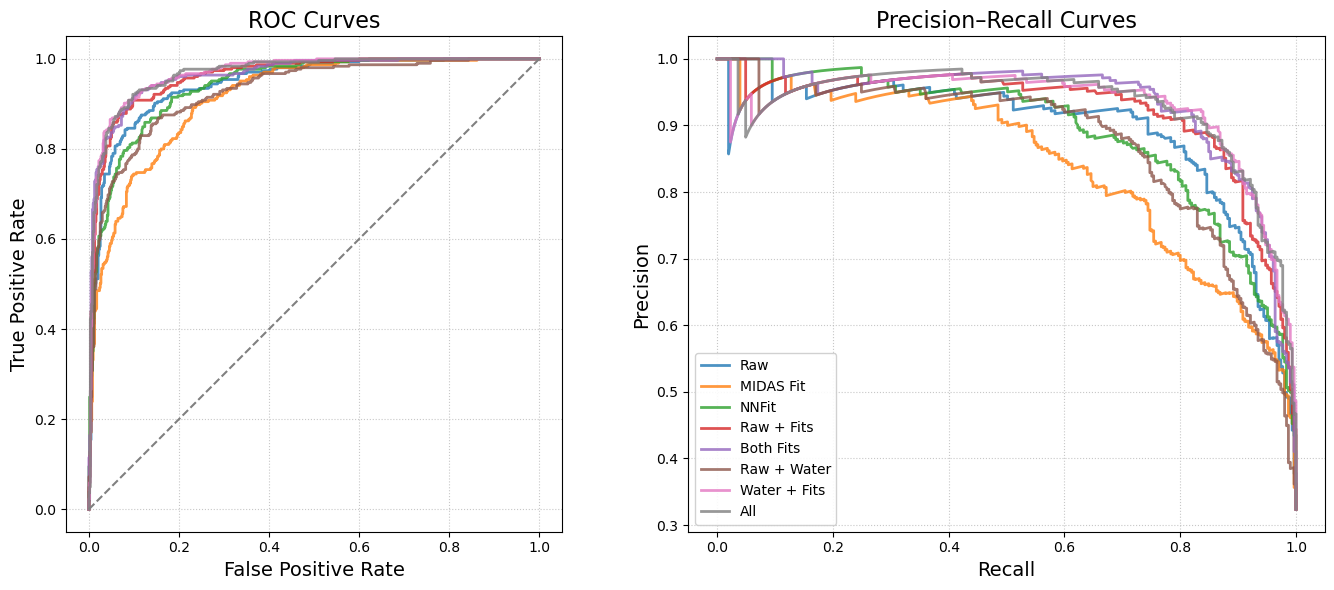

In [33]:
# Load saved data
with open(output_dir / "ensemble_metrics_data.pkl", "rb") as f:
    metrics_data = pickle.load(f)

# ── Labels and ordering ────────────────────────────────────────────────────
label_map = {
    'baseline_raw':  'Raw',
    'raw+water':     'Raw + Water',
    'raw+fits':      'Raw + Fits',
    'all_four':      'All',
    'fits+water':    'Water + Fits',
    'fit1_only':     'MIDAS Fit',
    'fit2_only':     'NNFit',
    'fits_combined': 'Both Fits'
}
exp_order = [
    'baseline_raw', 'fit1_only', 'fit2_only', 'raw+fits', 'fits_combined',
     'raw+water', 'fits+water', 'all_four',
]

# ── Preprocess test labels if not already in scope ────────────────────────
# (Assumes y_te exists; otherwise reload preprocess and test_data to get y_te)

# ── 1. Side-by-side ROC and PR curves ──────────────────────────────────────
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

# ROC curves
for key in exp_order:
    d = metrics_data[key]
    ax_roc.plot(d["fpr"], d["tpr"], label=label_map[key], linewidth=2, alpha=0.8)
ax_roc.plot([0, 1], [0, 1], "--", color="gray", linewidth=1.5)
ax_roc.set_xlabel("False Positive Rate", fontsize=14)
ax_roc.set_ylabel("True Positive Rate", fontsize=14)
ax_roc.set_title("ROC Curves", fontsize=16)
ax_roc.grid(linestyle=":", alpha=0.7)
#ax_roc.legend(fontsize=10, framealpha=0.9, loc="lower right")
ax_roc.set_aspect("equal", "box")

# Precision-Recall curves
for key in exp_order:
    d = metrics_data[key]
    precision, recall, _ = precision_recall_curve(y_te, d["y_prob"])
    ap = metrics_data[key]["average_precision"]
    ax_pr.plot(recall, precision, label=f"{label_map[key]}",
               linewidth=2, alpha=0.8)
ax_pr.set_xlabel("Recall", fontsize=14)
ax_pr.set_ylabel("Precision", fontsize=14)
ax_pr.set_title("Precision–Recall Curves", fontsize=16)
ax_pr.grid(linestyle=":", alpha=0.7)
ax_pr.legend(fontsize=10, framealpha=0.9, loc="lower left")
plt.tight_layout()
plt.show()

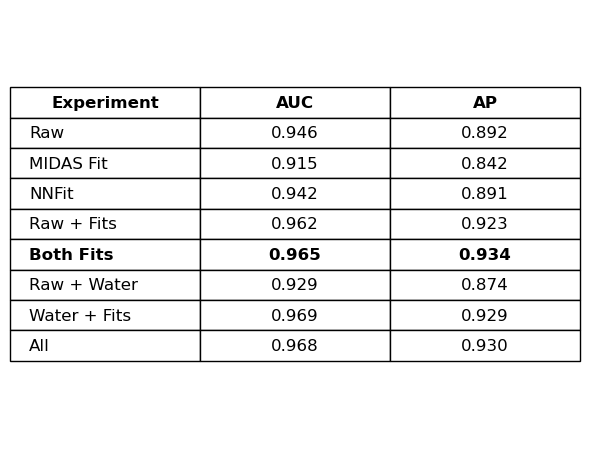

In [34]:
# Build DataFrame for the table
rows = []
for key in exp_order:
    d = metrics_data[key]
    rows.append([label_map[key], f"{d['auc']:.3f}", f"{d['average_precision']:.3f}"])
df = pd.DataFrame(rows, columns=["Experiment", "AUC", "AP"])

# ── Compute the best combined AUC+AP to bold ─────────────────────────────
scores = df['AUC'].astype(float) + df['AP'].astype(float)
best_idx = scores.idxmax()  # row index in df

# ── Create matplotlib table ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, len(df)*0.45 + 1))
ax.axis("off")
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    loc="center"
)

# ── Style table cells ────────────────────────────────────────────────────
for (row, col), cell in table.get_celld().items():
    text = cell.get_text()
    # Header row: bold labels
    if row == 0:
        text.set_fontweight('bold')
        cell.set_text_props(ha='center')
    else:
        # Left-align experiment names
        if col == 0:
            text.set_ha('left')
        # Bold the best experiment row
        if (row - 1) == best_idx:
            text.set_fontweight('bold')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()